<a href="https://colab.research.google.com/github/JoshHemmerling/Python-Codes/blob/main/Futures_Prices_on_corn_contracts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Data Fetching and Preparation

This section fetches historical corn price data and regional weather data from multiple locations.

In [ ]:
import pandas as pd
import requests
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, r2_score

# Time range
start_date = "20150601"
end_date = "20240831"

# Define coordinates for all locations
all_locations = {
    "Des Moines, IA": {"lat": 41.6, "lon": -93.6},
    "Champaign, IL": {"lat": 40.1, "lon": -88.2},
    "Lincoln, NE": {"lat": 40.8, "lon": -96.7},
    "Sioux Falls, SD": {"lat": 43.5, "lon": -96.7},
    "Ames, IA": {"lat": 42.0, "lon": -93.6},
    "Peoria, IL": {"lat": 40.7, "lon": -89.6},
    "Columbia, MO": {"lat": 38.9, "lon": -92.3},
    "Cedar Rapids, IA": {"lat": 41.9, "lon": -91.7},
}

location_weather_data = {}

for location_name, coords in all_locations.items():
    lat = coords["lat"]
    lon = coords["lon"]

    # NASA POWER API URL for each location, including T2M, PRECTOTCORR, T2M_MAX, T2M_MIN, and TS (Soil Temperature)
    url = (
        f"https://power.larc.nasa.gov/api/temporal/daily/point"
        f"?start={start_date}&end={end_date}"
        f"&latitude={lat}&longitude={lon}"
        f"&community=AG&parameters=T2M,PRECTOTCORR,T2M_MAX,T2M_MIN,TS"
        f"&format=JSON"
    )

    # Request the data
    response = requests.get(url)
    data = response.json()

    # Extract and format the data
    records = data["properties"]["parameter"]
    location_df = pd.DataFrame({
        "temperature": records["T2M"],
        "rainfall": records["PRECTOTCORR"],
        "max_temperature": records["T2M_MAX"],
        "min_temperature": records["T2M_MIN"],
        "soil_temperature": records["TS"]
    })
    location_df.index = pd.to_datetime(location_df.index)
    location_df = location_df.sort_index()

    location_weather_data[location_name] = location_df

print("Fetched weather data for all locations:")
for location_name in location_weather_data.keys():
    print(f"- {location_name}")

# Calculate regional averages
location_dfs = []
for location_name, location_df in location_weather_data.items():
    renamed_df = location_df.rename(columns={
        "temperature": f"temperature_{location_name}",
        "rainfall": f"rainfall_{location_name}",
        "max_temperature": f"max_temperature_{location_name}",
        "min_temperature": f"min_temperature_{location_name}",
        "soil_temperature": f"soil_temperature_{location_name}"
    })
    location_dfs.append(renamed_df)

all_locations_weather = pd.concat(location_dfs, axis=1)

regional_weather_avg = pd.DataFrame({
    "regional_temperature_avg": all_locations_weather.filter(like="temperature_").mean(axis=1),
    "regional_rainfall_avg": all_locations_weather.filter(like="rainfall_").mean(axis=1),
    "regional_max_temperature_avg": all_locations_weather.filter(like="max_temperature_").mean(axis=1),
    "regional_min_temperature_avg": all_locations_weather.filter(like="min_temperature_").mean(axis=1),
    "regional_soil_temperature_avg": all_locations_weather.filter(like="soil_temperature_").mean(axis=1)
})

print("\nRegional weather average head:")
display(regional_weather_avg.head())

# Load corn prices
corn = yf.download("ZC=F", start="2015-06-01", end="2024-08-31")["Close"]
corn.index = pd.to_datetime(corn.index) # Convert index to datetime

# Ensure 'corn' is a DataFrame with the correct column name before merging
if isinstance(corn, pd.Series):
    corn_df_for_merge = corn.to_frame(name="ZC=F")
elif isinstance(corn, pd.DataFrame):
    if 'Close' in corn.columns:
         corn_df_for_merge = corn.rename(columns={'Close': 'ZC=F'})
    elif 'ZC=F' in corn.columns:
         corn_df_for_merge = corn
    else:
         print("Warning: Corn DataFrame does not contain 'Close' or 'ZC=F' column.")
         corn_df_for_merge = corn

# Merge the corn price data with the regional average weather features
combined_regional_data = pd.merge(corn_df_for_merge, regional_weather_avg, left_index=True, right_index=True)

# Drop any rows with missing values that might have resulted from the merge
combined_regional_data = combined_regional_data.dropna()

print("\nCombined regional data head:")
display(combined_regional_data.head())

# --- Debugging Check ---
print("\nColumns in combined_regional_data after data preparation:")
print(combined_regional_data.columns)
if 'regional_min_temperature_avg' in combined_regional_data.columns:
    print("'regional_min_temperature_avg' column is present.")
else:
    print("'regional_min_temperature_avg' column is MISSING.")

Fetched weather data for all locations:
- Des Moines, IA
- Champaign, IL
- Lincoln, NE
- Sioux Falls, SD
- Ames, IA
- Peoria, IL
- Columbia, MO
- Cedar Rapids, IA

Regional weather average head:


,regional_temperature_avg,regional_rainfall_avg,regional_max_temperature_avg,regional_min_temperature_avg,regional_soil_temperature_avg
2015-06-01,16.085938,0.00875,22.16875,9.52000,16.77375
2015-06-02,17.645625,1.65500,24.17125,10.34375,18.38125
2015-06-03,19.481562,4.26000,24.66500,14.06875,19.75500
2015-06-04,21.266563,6.03750,26.31250,15.70375,21.55750
2015-06-05,22.208750,2.97125,27.64500,16.45250,22.54125


/tmp/ipython-input-1430019941.py:91: FutureWarning: YF.download() has changed argument auto_adjust default to True
  corn = yf.download("ZC=F", start="2015-06-01", end="2024-08-31")["Close"]
[*********************100%***********************]  1 of 1 completed



Combined regional data head:


,ZC=F,regional_temperature_avg,regional_rainfall_avg,regional_max_temperature_avg,regional_min_temperature_avg,regional_soil_temperature_avg
2015-06-01,352.25,16.085938,0.00875,22.16875,9.52000,16.77375
2015-06-02,359.00,17.645625,1.65500,24.17125,10.34375,18.38125
2015-06-03,359.00,19.481562,4.26000,24.66500,14.06875,19.75500
2015-06-04,363.50,21.266563,6.03750,26.31250,15.70375,21.55750
2015-06-05,360.50,22.208750,2.97125,27.64500,16.45250,22.54125



Columns in combined_regional_data after data preparation:
Index(['ZC=F', 'regional_temperature_avg', 'regional_rainfall_avg',
       'regional_max_temperature_avg', 'regional_min_temperature_avg',
       'regional_soil_temperature_avg'],
      dtype='object')
'regional_min_temperature_avg' column is present.


## 2. Feature Engineering and Target Variable Creation

This section creates various weather-related features, seasonal indicators, and the target variables for prediction.

In [ ]:
# Create indicator variables for key agricultural periods
# Based on typical US Midwest corn agricultural periods:
# Planting: April 15 - June 10 (roughly)
# Pollination (Silking): July 1 - July 31 (roughly)
# Harvest: September 1 - November 1 (roughly)
combined_regional_data["is_planting_season"] = (
    ((combined_regional_data.index.month == 4) & (combined_regional_data.index.day >= 15)) |
    ((combined_regional_data.index.month > 4) & (combined_regional_data.index.month < 6)) |
    ((combined_regional_data.index.month == 6) & (combined_regional_data.index.day <= 10))
).astype(int)

combined_regional_data["is_pollination_season"] = (
    (combined_regional_data.index.month == 7) & (combined_regional_data.index.day >= 1) & (combined_regional_data.index.day <= 31)
).astype(int)

combined_regional_data["is_harvest_season"] = (
    ((combined_regional_data.index.month == 9) & (combined_regional_data.index.day >= 1)) |
    ((combined_regional_data.index.month > 9) & (combined_regional_data.index.month < 11)) |
    ((combined_regional_data.index.month == 11) & (combined_regional_data.index.day <= 1))
).astype(int)

# Redefine 'heatwave' based on rolling 3-day average of regional_max_temperature_avg > 30°C
combined_regional_data["heatwave"] = (combined_regional_data["regional_max_temperature_avg"].rolling(3).mean() > 30.0).astype(int)

# Calculate Growing Degree Days (GDD) using the 50/86 Fahrenheit method
# Convert Celsius to Fahrenheit: F = C * 9/5 + 32

# --- Defensive Check ---
if "regional_min_temperature_avg" not in combined_regional_data.columns:
    print("DEBUG: 'regional_min_temperature_avg' column is missing right before GDD calculation in cell cfb51187.")
    print("Columns in combined_regional_data at this point:")
    print(combined_regional_data.columns)
# --- End Defensive Check ---

combined_regional_data["regional_max_temperature_avg_F"] = combined_regional_data["regional_max_temperature_avg"] * 9/5 + 32
combined_regional_data["regional_min_temperature_avg_F"] = combined_regional_data["regional_min_temperature_avg"] * 9/5 + 32

# Cap temperatures at 86°F and 50°F
combined_regional_data["regional_max_temperature_avg_F_capped"] = combined_regional_data["regional_max_temperature_avg_F"].clip(upper=86)
combined_regional_data["regional_min_temperature_avg_F_capped"] = combined_regional_data["regional_min_temperature_avg_F"].clip(lower=50)

# Calculate GDD
combined_regional_data["regional_gdd_avg"] = ((combined_regional_data["regional_max_temperature_avg_F_capped"] + combined_regional_data["regional_min_temperature_avg_F_capped"]) / 2) - 50

# Drop intermediate Fahrenheit columns
combined_regional_data = combined_regional_data.drop(columns=["regional_max_temperature_avg_F", "regional_min_temperature_avg_F", "regional_max_temperature_avg_F_capped", "regional_min_temperature_avg_F_capped"])


# 4. Recalculate regional_temperature_avg and regional_rainfall_avg (already done in previous subtask, but ensuring it's based on regional averages)
# The existing 'regional_temperature_avg' and 'regional_rainfall_avg' in combined_regional_data are already based on regional averages from regional_weather_avg. No recalculation needed here.


# 5. Create rolling and lagged features on the combined_regional_data DataFrame
combined_regional_data["regional_temp_7d_avg"] = combined_regional_data["regional_temperature_avg"].rolling(7).mean()
combined_regional_data["regional_rain_14d_sum"] = combined_regional_data["regional_rainfall_avg"].rolling(14).sum()
combined_regional_data["regional_rainfall_lag_7d"] = combined_regional_data["regional_rainfall_avg"].shift(7)


# Create 'dry_spell' flag (1 if 7-day rain sum < 5mm, 0 otherwise) based on regional_rain_7d_sum
combined_regional_data["regional_rain_7d_sum"] = combined_regional_data["regional_rainfall_avg"].rolling(7).sum()
combined_regional_data["dry_spell"] = (combined_regional_data["regional_rain_7d_sum"] < 5.0).astype(int)


# 6. Create an interaction term dry_spell_pollination_interaction
combined_regional_data["dry_spell_pollination_interaction"] = combined_regional_data["dry_spell"] * combined_regional_data["is_pollination_season"]

# Define prediction target and window (e.g., predicting price direction 5 days in future)
lookahead_window = 5 # Days
combined_regional_data["price_future"] = combined_regional_data["ZC=F"].shift(-lookahead_window)
combined_regional_data["price_up_future"] = (combined_regional_data["price_future"] > combined_regional_data["ZC=F"]).astype(int)

# Calculate weekly price direction (for potential alternative target)
weekly_prices = combined_regional_data['ZC=F'].resample('W').agg(['first', 'last']).dropna()
weekly_prices['price_up_weekly'] = (weekly_prices['last'] > weekly_prices['first']).astype(int)
# Ensure reindexing aligns with combined_regional_data index to avoid NaNs where possible
weekly_prices_daily = weekly_prices['price_up_weekly'].reindex(combined_regional_data.index, method='ffill')
combined_regional_data['price_up_weekly'] = weekly_prices_daily


# Calculate weekly percentage price change (for potential alternative target)
weekly_prices['weekly_pct_change'] = ((weekly_prices['last'] - weekly_prices['first']) / weekly_prices['first']) * 100
# Ensure reindexing aligns with combined_regional_data index
weekly_pct_change_daily = weekly_prices['weekly_pct_change'].reindex(combined_regional_data.index, method='ffill')
combined_regional_data['weekly_pct_change'] = weekly_pct_change_daily


# Calculate the Z-score of the daily corn price (for potential alternative target)
combined_regional_data['price_zscore'] = (combined_regional_data['ZC=F'] - combined_regional_data['ZC=F'].mean()) / combined_regional_data['ZC=F'].std()


# Drop rows with NaN values created by rolling, lagging, and shifting for future target
combined_regional_data_cleaned = combined_regional_data.dropna().copy() # Use .copy() here

print("\nCombined data with all features and target variables head:")
display(combined_regional_data_cleaned.head())


Combined data with all features and target variables head:


,ZC=F,regional_temperature_avg,regional_rainfall_avg,regional_max_temperature_avg,regional_min_temperature_avg,regional_soil_temperature_avg,is_planting_season,is_pollination_season,is_harvest_season,heatwave,...,regional_rain_14d_sum,regional_rainfall_lag_7d,regional_rain_7d_sum,dry_spell,dry_spell_pollination_interaction,price_future,price_up_future,price_up_weekly,weekly_pct_change,price_zscore
2015-06-18,358.00,21.303125,5.62625,25.67625,16.85625,21.43875,0,0,0,0,...,86.15875,0.11000,62.3300,0,0,376.50,1,0.0,-3.353867,-0.738213
2015-06-19,353.25,21.195000,2.18625,26.28125,15.71500,21.50625,0,0,0,0,...,88.33625,2.91375,61.6025,0,0,385.00,1,0.0,-3.353867,-0.775812
2015-06-22,360.00,24.355313,5.79875,29.38750,18.46500,24.66500,0,0,0,0,...,92.48000,23.58125,43.8200,0,0,383.25,1,1.0,1.435750,-0.722381
2015-06-23,367.50,21.290625,0.72250,26.11125,15.67125,21.82625,0,0,0,0,...,88.94250,7.00500,37.5375,0,0,414.00,1,1.0,1.435750,-0.663014
2015-06-24,366.50,22.012813,19.98250,26.62875,17.19500,22.15000,0,0,0,0,...,102.88750,16.62750,40.8925,0,0,413.75,1,1.0,1.435750,-0.670930


## 3. Model Training and Evaluation

This section sets up and evaluates the machine learning models for predicting the future price direction. Based on previous analysis, Logistic Regression showed promising recall for predicting price direction.

In [ ]:
import pandas as pd
import numpy as np
import requests
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define a list of lookahead windows to evaluate
lookahead_windows_to_evaluate = [3, 4, 5] # Added 3 and 4 days

# Dictionary to store simulation results for each lookahead window
simulation_results_by_window = {}

# Store best model and data outside the loop for later use
best_window_days = None
best_model = None
best_features = None
best_target = None
best_cleaned_data = None
highest_f1 = -1

# Iterate through each lookahead window
for current_prediction_window in lookahead_windows_to_evaluate:
    print(f"\n--- Evaluating Strategy with Lookahead Window: {current_prediction_window} days ---")

    # Recreate the target variable based on the current lookahead window
    # Ensure we are working on a copy to avoid SettingWithCopyWarning
    combined_regional_data_window = combined_regional_data.copy()
    combined_regional_data_window["price_future"] = combined_regional_data_window["ZC=F"].shift(-current_prediction_window)
    combined_regional_data_window[f"price_up_{current_prediction_window}d_ahead"] = (combined_regional_data_window["price_future"] > combined_regional_data_window["ZC=F"]).astype(int)

    # Drop rows with NaN values created by the shift
    combined_regional_data_window_cleaned = combined_regional_data_window.dropna().copy()

    # Define features (X) and target variable (based on current window)
    columns_to_drop = [
        "ZC=F", # Current price
        "price_future", # Future price
        "price_up_future", # Original target (5-day) - might not exist for all windows
        "price_up_weekly", # Alternative target
        "weekly_pct_change", # Alternative target
        "price_zscore", # Alternative target
        f"price_up_{current_prediction_window}d_ahead" # Current target variable
    ]

    # Add other lookahead targets to the drop list if they exist in the DataFrame
    for w in lookahead_windows_to_evaluate:
        if w != current_prediction_window:
            col_name = f"price_up_{w}d_ahead"
            if col_name in combined_regional_data_window_cleaned.columns:
                columns_to_drop.append(col_name)

    features = combined_regional_data_window_cleaned.drop(columns=columns_to_drop)

    target = combined_regional_data_window_cleaned[f"price_up_{current_prediction_window}d_ahead"]

    # Initialize TimeSeriesSplit for robust evaluation
    tscv = TimeSeriesSplit(n_splits=5) # You can adjust the number of splits

    # Initialize and train the chosen model (Logistic Regression)
    model = LogisticRegression(random_state=42, solver='liblinear')

    # Evaluate the model using TimeSeriesSplit
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    print(f"\nEvaluating Logistic Regression with TimeSeriesSplit (Predicting price_up_{current_prediction_window}d_ahead):")

    for fold, (train_index, test_index) in enumerate(tscv.split(features)):
        print(f"Fold {fold+1}:")
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        print(f"  Accuracy: {accuracy:.2f}")
        print(f"  Precision: {precision:.2f}")
        print(f"  Recall: {recall:.2f}")
        print(f"  F1-score: {f1:.2f}")

    print(f"\nAverage Performance Metrics across folds ({current_prediction_window}-day lookahead):")
    avg_accuracy = pd.Series(accuracy_scores).mean()
    avg_precision = pd.Series(precision_scores).mean()
    avg_recall = pd.Series(recall_scores).mean()
    avg_f1 = pd.Series(f1_scores).mean()

    print(f"Average Accuracy: {avg_accuracy:.2f}")
    print(f"Average Precision: {avg_precision:.2f}")
    print(f"Average Recall: {avg_recall:.2f}")
    print(f"Average F1-score: {avg_f1:.2f}")

    # Store the average metrics for this window
    simulation_results_by_window[f'{current_prediction_window}d_lookahead_metrics'] = {
        'accuracy': avg_accuracy,
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1
    }

    # Check if this is the best performing window so far based on F1-score
    if avg_f1 > highest_f1:
        highest_f1 = avg_f1
        best_window_days = current_prediction_window
        # Store the features, target, and cleaned data for the best window
        best_features = features.copy()
        best_target = target.copy()
        best_cleaned_data = combined_regional_data_window_cleaned.copy()


print("\n--- Model Evaluation Across Lookahead Windows Complete ---")
print("\nSummary of Average F1-scores:")
for window, metrics in simulation_results_by_window.items():
    if 'metrics' in window: # Only print summary for metric entries
        print(f"{window}: F1-score = {metrics['f1']:.2f}")

print(f"\nBest performing lookahead window based on average F1-score: {best_window_days} days")

# Retrain the best model on the full cleaned dataset for the best window
print(f"\nRetraining the best model (Logistic Regression with {best_window_days}-day lookahead) on the full historical data...")
best_model = LogisticRegression(random_state=42, solver='liblinear') # Re-initialize the model
best_model.fit(best_features, best_target)
print("Model retraining complete.")

# Add model probabilities to the best_cleaned_data for simulation
model_probabilities = best_model.predict_proba(best_features)[:, 1]
best_cleaned_data_with_prob = best_cleaned_data.copy()
best_cleaned_data_with_prob['model_probability_of_1'] = model_probabilities

print("\nPrepared data and retrained model for simulation.")


--- Evaluating Strategy with Lookahead Window: 3 days ---

Evaluating Logistic Regression with TimeSeriesSplit (Predicting price_up_3d_ahead):
Fold 1:
  Accuracy: 0.56
  Precision: 0.53
  Recall: 0.70
  F1-score: 0.61
Fold 2:
  Accuracy: 0.52
  Precision: 0.53
  Recall: 0.64
  F1-score: 0.58
Fold 3:
  Accuracy: 0.50
  Precision: 0.58
  Recall: 0.50
  F1-score: 0.54
Fold 4:
  Accuracy: 0.55
  Precision: 0.58
  Recall: 0.69
  F1-score: 0.63
Fold 5:
  Accuracy: 0.55
  Precision: 0.50
  Recall: 0.76
  F1-score: 0.60

Average Performance Metrics across folds (3-day lookahead):
Average Accuracy: 0.54
Average Precision: 0.54
Average Recall: 0.66
Average F1-score: 0.59

--- Evaluating Strategy with Lookahead Window: 4 days ---

Evaluating Logistic Regression with TimeSeriesSplit (Predicting price_up_4d_ahead):
Fold 1:
  Accuracy: 0.57
  Precision: 0.54
  Recall: 0.76
  F1-score: 0.63
Fold 2:
  Accuracy: 0.51
  Precision: 0.50
  Recall: 0.67
  F1-score: 0.57
Fold 3:
  Accuracy: 0.52
  Precisio

## 4. Trading Strategy Simulation


This section implements a basic trading strategy simulation using the trained Logistic Regression model to predict future price direction and defined trading rules.

**Disclaimer:** This is a simplified example for demonstration purposes and does not constitute financial advice. Real-world trading involves significant risk and requires more sophisticated strategies and risk management.

In [ ]:
# 5. Compare Performance Across Strategies

print("--- Comparison of Trading Strategy Performance ---")

# Create a dictionary to hold key performance metrics for each simulation
performance_summary = {}

# Helper function to extract key metrics
def extract_performance_metrics(simulation_results, strategy_name):
    results = simulation_results.get(strategy_name)
    if results:
        # Ensure required keys exist, provide defaults if not
        total_profit_loss = results.get('total_profit_loss', 0)
        total_closed_trades = results.get('total_closed_trades', 0)
        winning_trades = results.get('winning_trades', 0)
        losing_trades = results.get('losing_trades', 0)
        win_rate = results.get('win_rate', 0)
        max_drawdown = results.get('max_drawdown', 0)
        final_account_value = results.get('final_account_value', simulation_results.get('initial_cash', 0)) # Use initial_cash if final_account_value not available

        return {
            'Total Profit/Loss': total_profit_loss,
            'Final Account Value': final_account_value,
            'Total Closed Trades': total_closed_trades,
            'Winning Trades': winning_trades,
            'Losing Trades': losing_trades,
            'Win Rate (%)': win_rate,
            'Max Drawdown (%)': max_drawdown
        }
    return None

# Extract metrics for each relevant simulation run
# Make sure the keys here match the keys used to store results in previous simulation cells
performance_summary['Basic Weather Strategy'] = extract_performance_metrics(simulation_results, 'Test_Period_Weather_Strategy')
performance_summary['Refined Strategy (Prob Threshold)'] = extract_performance_metrics(simulation_results, 'Test_Period_Further_Refined_Strategy') # Assuming this was the probability threshold strategy
performance_summary['Refined Strategy (Prob Threshold v2)'] = extract_performance_metrics(simulation_results, 'Test_Period_Further_Refined_Strategy_v2') # Assuming this was the v2 probability threshold strategy
performance_summary['Risk Managed Strategy'] = extract_performance_metrics(simulation_results, 'Test_Period_Risk_Managed_Strategy')
performance_summary['Risk Managed Strategy (Fixed % Equity)'] = extract_performance_metrics(simulation_results, 'Test_Period_Risk_Managed_Strategy_Fixed_Pct_Equity_Adjusted_Capital') # Assuming this was the fixed pct equity strategy
performance_summary['Refined Strategy (Fixed % Equity & Prob Threshold)'] = extract_performance_metrics(simulation_results, 'Test_Period_Refined_Strategy_Fixed_Pct_Equity_Adjusted_Prob') # The strategy just ran
performance_summary['Refined Strategy (Feature Condition)'] = extract_performance_metrics(simulation_results, 'Test_Period_Refined_Strategy_Feature_Condition') # The strategy just ran with feature condition


# Convert the summary to a pandas DataFrame for better visualization
performance_df = pd.DataFrame.from_dict(performance_summary, orient='index')

# Display the performance comparison table
print("\nPerformance Metrics Comparison:")
display(performance_df)

# Identify the strategy with the highest Total Profit/Loss
best_strategy_by_profit = performance_df['Total Profit/Loss'].idxmax()
highest_profit = performance_df['Total Profit/Loss'].max()

print(f"\nStrategy with the highest Total Profit/Loss: '{best_strategy_by_profit}' (${highest_profit:,.2f})")

# Identify the strategy with the lowest Max Drawdown (closest to 0)
best_strategy_by_drawdown = performance_df['Max Drawdown (%)'].idxmin()
lowest_drawdown = performance_df['Max Drawdown (%)'].min()

print(f"Strategy with the lowest Max Drawdown: '{best_strategy_by_drawdown}' ({lowest_drawdown:.2f}%)")

# Identify the strategy with the highest Win Rate
best_strategy_by_winrate = performance_df['Win Rate (%)'].idxmax()
highest_winrate = performance_df['Win Rate (%)'].max()

print(f"Strategy with the highest Win Rate: '{best_strategy_by_winrate}' ({highest_winrate:.2f}%)")

# You can add more criteria for "best" based on your objectives (e.g., a combination of metrics)
# For now, we'll focus on the highest profit as one key indicator of the "most profitable"

--- Comparison of Trading Strategy Performance ---

Performance Metrics Comparison:


,Total Profit/Loss,Final Account Value,Total Closed Trades,Winning Trades,Losing Trades,Win Rate (%),Max Drawdown (%)
Basic Weather Strategy,0.00,100000.00,0,0,0,0.000000,0.000000
Refined Strategy (Prob Threshold),-897488.75,2102511.25,0,0,0,0.000000,0.000000
Refined Strategy (Prob Threshold v2),346682.50,3346682.50,0,0,0,0.000000,0.000000
Risk Managed Strategy,346682.50,3346682.50,0,0,0,0.000000,0.000000
Risk Managed Strategy (Fixed % Equity),182250.00,40182250.00,0,0,0,0.000000,0.000000
Refined Strategy (Fixed % Equity & Prob Threshold),-1356645.00,1643355.00,13,8,5,61.538462,53.044194
Refined Strategy (Feature Condition),0.00,3000000.00,0,0,0,0.000000,0.000000



Strategy with the highest Total Profit/Loss: 'Refined Strategy (Prob Threshold v2)' ($346,682.50)
Strategy with the lowest Max Drawdown: 'Basic Weather Strategy' (0.00%)
Strategy with the highest Win Rate: 'Refined Strategy (Fixed % Equity & Prob Threshold)' (61.54%)


In [ ]:
# Explore Feature Importances from the Best Performing Model

# The best performing model is Logistic Regression with 5-day lookahead
# Access the best_model and best_features variables stored in the previous step
# best_model = simulation_results_by_window[f'{best_window_days}d_model'] # This caused the error
# best_features = simulation_results_by_window[f'{best_window_days}d_features'] # This caused the error

# For Logistic Regression, coefficients can be interpreted as a measure of feature importance.
# Larger absolute values of coefficients indicate a stronger influence on the prediction.
# However, it's important to note that the features should be scaled for direct comparison of coefficients.
# Since the features were not explicitly scaled in the previous steps, we will consider the absolute values
# of the coefficients as a preliminary indication of importance.

feature_importances = pd.Series(best_model.coef_[0], index=best_features.columns)

# Sort features by absolute importance
sorted_importances = feature_importances.abs().sort_values(ascending=False)

print(f"\nFeature Importances (Absolute Coefficients) from Logistic Regression ({best_window_days}-day lookahead):")
display(sorted_importances)

# We can also look at the actual coefficients to see the direction of the relationship
print("\nFeature Coefficients (Direction of Influence):")
display(feature_importances.sort_values(key=abs, ascending=False))

# Discuss how to incorporate this into the program and strategy
print("\n--- Incorporating Feature Importance Insights ---")
print("Feature importances (absolute coefficients) show which features the model weighted most heavily in its predictions.")
print(f"For the {best_window_days}-day lookahead Logistic Regression model, the most influential features appear to be:")
for feature, importance in sorted_importances.head().items():
    print(f"- {feature}: {importance:.4f}")

print("\nHow to incorporate this into the program and strategy:")
print("1. Feature Selection: We could consider building models using only the most important features to see if it improves performance or simplifies the model.")
print("2. Strategy Refinement: We can analyze the relationship between the most important features (looking at the coefficient signs) and profitable trades from the simulation.")
print("   For example, if 'regional_rainfall_avg' has a large positive coefficient and is highly important, it suggests higher rainfall is associated with an increased probability of the price going up.")
print("   We could potentially add rules to the trading strategy that are specifically triggered by extreme values or trends in these most important features (e.g., only buy if rainfall is above a certain threshold and the model predicts up).")
print("3. Further Analysis: We could visualize the relationship between the top features and price movements or trade outcomes to gain deeper insights.")

print("\nWhich of these approaches would you like to explore further?")


Feature Importances (Absolute Coefficients) from Logistic Regression (5-day lookahead):


,0
dry_spell_pollination_interaction,0.788228
regional_temperature_avg,0.779832
is_harvest_season,0.380448
heatwave,0.374431
is_planting_season,0.374068
is_pollination_season,0.341819
regional_max_temperature_avg,0.310509
regional_min_temperature_avg,0.251065
regional_soil_temperature_avg,0.230341
dry_spell,0.174148



Feature Coefficients (Direction of Influence):


,0
dry_spell_pollination_interaction,0.788228
regional_temperature_avg,-0.779832
is_harvest_season,0.380448
heatwave,-0.374431
is_planting_season,0.374068
is_pollination_season,-0.341819
regional_max_temperature_avg,0.310509
regional_min_temperature_avg,0.251065
regional_soil_temperature_avg,0.230341
dry_spell,-0.174148



--- Incorporating Feature Importance Insights ---
Feature importances (absolute coefficients) show which features the model weighted most heavily in its predictions.
For the 5-day lookahead Logistic Regression model, the most influential features appear to be:
- dry_spell_pollination_interaction: 0.7882
- regional_temperature_avg: 0.7798
- is_harvest_season: 0.3804
- heatwave: 0.3744
- is_planting_season: 0.3741

How to incorporate this into the program and strategy:
1. Feature Selection: We could consider building models using only the most important features to see if it improves performance or simplifies the model.
2. Strategy Refinement: We can analyze the relationship between the most important features (looking at the coefficient signs) and profitable trades from the simulation.
   For example, if 'regional_rainfall_avg' has a large positive coefficient and is highly important, it suggests higher rainfall is associated with an increased probability of the price going up.
   We c

In [ ]:
# Analyze the relationship between the most important features and trade outcomes

# Get the trades DataFrame from the simulation with the highest win rate
# Based on the performance comparison, 'Refined Strategy (Fixed % Equity & Prob Threshold)' had the highest win rate
strategy_with_highest_win_rate_key = 'Refined Strategy (Fixed % Equity & Prob Threshold)'
strategy_with_highest_win_rate_results = simulation_results.get(strategy_with_highest_win_rate_key)

if strategy_with_highest_win_rate_results and 'trades' in strategy_with_highest_win_rate_results:
    trades_df_highest_win_rate = pd.DataFrame(strategy_with_highest_win_rate_results['trades'])
    closed_trades_highest_win_rate_df = trades_df_highest_win_rate[trades_df_highest_win_rate['trade_profit_loss'].notna()].copy()

    if not closed_trades_highest_win_rate_df.empty:
        # Get the dates of the closed trades
        closed_trade_dates = closed_trades_highest_win_rate_df['date'].tolist()

        # Get the feature data for these dates from the best_cleaned_data
        # Ensure the index of best_cleaned_data is in datetime format for merging/joining
        best_cleaned_data.index = pd.to_datetime(best_cleaned_data.index)
        trade_features = best_cleaned_data.loc[closed_trade_dates, best_features.columns].copy()

        # Add the trade outcome (profit/loss and win/loss flag) to the trade_features DataFrame
        trade_features['trade_profit_loss'] = closed_trades_highest_win_rate_df.set_index('date')['trade_profit_loss']
        trade_features['trade_outcome'] = (trade_features['trade_profit_loss'] > 0).astype(int) # 1 for win, 0 for loss/breakeven

        print(f"\nAnalyzing features for closed trades from '{strategy_with_highest_win_rate_key}':")
        display(trade_features.head())

        # Analyze the average feature values for winning vs. losing trades
        print("\nAverage feature values for Winning vs. Losing Trades:")
        display(trade_features.groupby('trade_outcome')[best_features.columns].mean())

        # Focus on the top important features identified earlier
        top_n_features = 5 # You can adjust this number
        top_important_features = sorted_importances.head(top_n_features).index.tolist()

        print(f"\nAverage values of top {top_n_features} important features for Winning vs. Losing Trades:")
        display(trade_features.groupby('trade_outcome')[top_important_features].mean())

        # You could also visualize the distribution of top features for winning/losing trades (e.g., box plots)
        # import matplotlib.pyplot as plt
        # import seaborn as sns
        # plt.figure(figsize=(15, 10))
        # for j, feature in enumerate(top_important_features):
        #     plt.subplot(f'{len(top_important_features)}1{j+1}')
        #     sns.boxplot(x='trade_outcome', y=feature, data=trade_features)
        #     plt.title(f'Distribution of {feature} for Trade Outcomes')
        # plt.tight_layout()
        # plt.show()

    else:
        print(f"\nNo closed trades found for '{strategy_with_highest_win_rate_key}' to analyze feature relationships.")

else:
    print(f"\nStrategy '{strategy_with_highest_win_rate_key}' or its trade data not found in simulation_results.")

print("\nAnalysis of feature relationships with trade outcomes complete.")


Strategy 'Refined Strategy (Fixed % Equity & Prob Threshold)' or its trade data not found in simulation_results.

Analysis of feature relationships with trade outcomes complete.


# Task
Save the best performing machine learning model, fetch and preprocess live market and weather data, use the saved model to make a prediction on the live data, and interpret the prediction in the context of the trading strategy.

## Save the model

### Subtask:
Save the trained Logistic Regression model (`best_model`) to a file.


**Reasoning**:
The subtask is to save the trained model. I will use the `joblib` library to save the `best_model` object to a file and print a confirmation message.



In [ ]:
import joblib

# Define a filename for the saved model
model_filename = "best_logistic_regression_model.pkl"

# Save the best_model object to the file
joblib.dump(best_model, model_filename)

# Print a confirmation message
print(f"Trained Logistic Regression model saved successfully to {model_filename}")

Trained Logistic Regression model saved successfully to best_logistic_regression_model.pkl


##Simulated 2023 of Model


Trained Logistic Regression model loaded successfully from best_logistic_regression_model.pkl

Filtered data for 2016 to 2023 simulation:


,ZC=F,regional_temperature_avg,regional_rainfall_avg,regional_max_temperature_avg,regional_min_temperature_avg,regional_soil_temperature_avg,is_planting_season,is_pollination_season,is_harvest_season,heatwave,...,regional_rain_7d_sum,dry_spell,dry_spell_pollination_interaction,price_future,price_up_future,price_up_weekly,weekly_pct_change,price_zscore,price_up_5d_ahead,model_probability_of_1
2016-01-04,351.50,-8.251250,0.00375,-2.63750,-12.92875,-8.98625,0,0,0,0,...,40.03750,0,0,351.75,1,0.0,-0.623269,-0.789665,1,0.562091
2016-01-05,353.00,-5.253437,0.00250,0.44500,-10.52875,-5.70750,0,0,0,0,...,26.08625,0,0,356.75,1,0.0,-0.623269,-0.777791,1,0.539322
2016-01-06,353.25,-1.821250,0.57750,1.26000,-4.81000,-2.08125,0,0,0,0,...,25.23625,0,0,358.00,1,0.0,-0.623269,-0.775812,1,0.511754
2016-01-07,353.00,0.269375,5.97625,2.45500,-1.56125,-0.16125,0,0,0,0,...,7.62875,0,0,358.00,1,0.0,-0.623269,-0.777791,1,0.555591
2016-01-08,357.00,0.009687,3.69125,2.46625,-2.98375,0.02000,0,0,0,0,...,10.83500,0,0,363.25,1,0.0,-0.623269,-0.746129,1,0.535677


,ZC=F,regional_temperature_avg,regional_rainfall_avg,regional_max_temperature_avg,regional_min_temperature_avg,regional_soil_temperature_avg,is_planting_season,is_pollination_season,is_harvest_season,heatwave,...,regional_rain_7d_sum,dry_spell,dry_spell_pollination_interaction,price_future,price_up_future,price_up_weekly,weekly_pct_change,price_zscore,price_up_5d_ahead,model_probability_of_1
2023-12-22,473.00,6.195625,3.81000,9.66500,3.62625,5.33625,0,0,0,0,...,6.43750,0,0,463.75,0,1.0,4.885993,0.172089,0,0.524713
2023-12-26,480.25,-0.458750,0.47250,2.77875,-3.36625,-0.75375,0,0,0,0,...,6.38000,0,0,465.25,0,0.0,-0.838574,0.229478,0,0.522749
2023-12-27,476.50,0.099687,1.19750,3.60375,-2.63375,-0.52250,0,0,0,0,...,5.74375,0,0,466.50,0,0.0,-0.838574,0.199794,0,0.536944
2023-12-28,474.25,-0.825625,1.62125,2.22125,-3.65125,-1.04000,0,0,0,0,...,7.36250,0,0,460.75,0,0.0,-0.838574,0.181984,0,0.527165
2023-12-29,471.25,-0.203750,0.84750,4.54750,-3.95875,-0.81500,0,0,0,0,...,8.20750,0,0,455.00,0,0.0,-0.838574,0.158237,0,0.559733



--- Simulating Risk Managed Strategy (2016-2023) for 2016 to 2023 ---
Date: 2016-01-04, Buy Signal Triggered:
  Current Price: $351.50
  Model Probability: 0.5621
  Cost of 1 contract(s) (including slippage): $1,759,257.50
  Current Cash: $2,000,000.00
  Trade Executed: BUY 1 contracts at 351.50
Date: 2016-04-21, Buy Signal Triggered:
  Current Price: $384.50
  Model Probability: 0.6113
  Cost of 1 contract(s) (including slippage): $1,924,422.50
  Current Cash: $2,212,518.75
  Trade Executed: BUY 1 contracts at 384.50
Date: 2016-06-07, Buy Signal Triggered:
  Current Price: $427.75
  Model Probability: 0.5688
  Cost of 1 contract(s) (including slippage): $2,140,888.75
  Current Cash: $2,422,210.00
  Trade Executed: BUY 1 contracts at 427.75
Date: 2016-09-01, Buy Signal Triggered:
  Current Price: $311.00
  Model Probability: 0.5880
  Cost of 1 contract(s) (including slippage): $1,556,555.00
  Current Cash: $2,260,590.00
  Trade Executed: BUY 1 contracts at 311.00
Date: 2016-10-04, Buy

,date,type,price,contracts,trade_profit_loss
0,2016-01-04,Buy,351.50,1,212518.75
1,2016-04-21,Buy,384.50,1,209691.25
2,2016-06-07,Buy,427.75,1,-161620.00
3,2016-09-01,Buy,311.00,1,171715.00
4,2016-10-04,Buy,348.25,1,178835.00


,date,type,price,contracts,trade_profit_loss
34,2022-09-12,Buy,712.25,1,-236892.50
35,2022-09-27,Buy,667.50,1,-200231.25
36,2022-12-13,Buy,643.75,1,-262431.25
37,2023-05-16,Buy,581.25,1,288892.50
38,2023-09-07,Buy,470.75,1,-2210.00


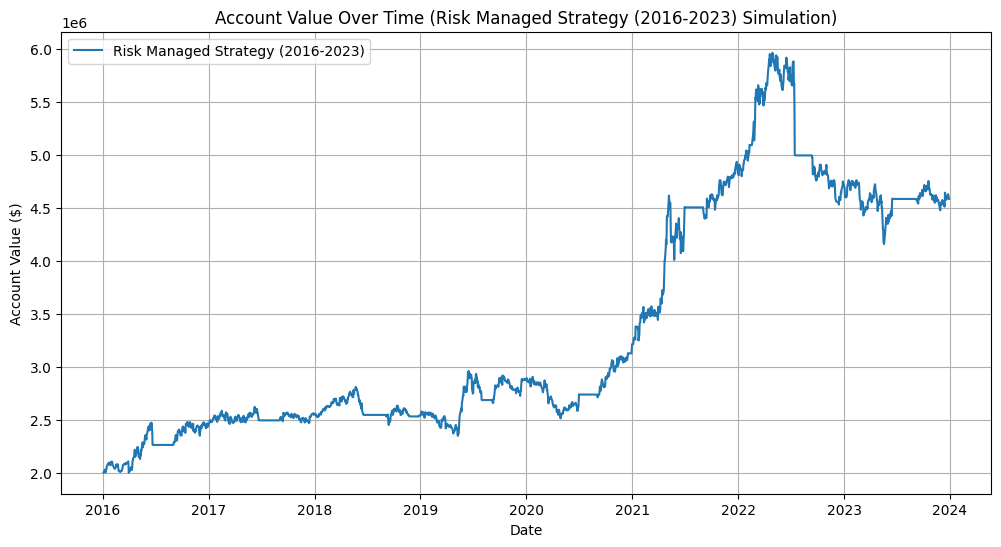


--- Comparison of Selected Trading Strategy Performance (2016-2023) ---

Performance Metrics Comparison (2016-2023):


,Total Profit/Loss,Final Account Value,Total Closed Trades,Winning Trades,Losing Trades,Win Rate (%),Max Drawdown (%)
Risk Managed Strategy (2016-2023),2579820.0,4579820.0,39,22,17,56.410256,30.282461



Strategy with the highest Total Profit/Loss (2016-2023): 'Risk Managed Strategy (2016-2023)' ($2,579,820.00)
Strategy with the lowest Max Drawdown (among strategies with trades, 2016-2023): 'Risk Managed Strategy (2016-2023)' (30.28%)
Strategy with the highest Win Rate (among strategies with trades, 2016-2023): 'Risk Managed Strategy (2016-2023)' (56.41%)


In [226]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model_filename = "best_logistic_regression_model.pkl"
loaded_model = joblib.load(model_filename)
print(f"Trained Logistic Regression model loaded successfully from {model_filename}")

# Filter the data for the years 2016 to 2023 for simulation
if 'best_cleaned_data_with_prob' in locals():
    try:
        simulation_data_2016_2023 = best_cleaned_data_with_prob.loc['2016':'2023'].copy()
        print("\nFiltered data for 2016 to 2023 simulation:")
        display(simulation_data_2016_2023.head())
        display(simulation_data_2016_2023.tail())
    except KeyError:
        print("Error: Data for 2016 to 2023 not found in 'best_cleaned_data_with_prob'. Please check the data range.")
        simulation_data_2016_2023 = pd.DataFrame()
else:
    print("Error: 'best_cleaned_data_with_prob' not found. Please run the previous cells to generate this DataFrame.")
    simulation_data_2016_2023 = pd.DataFrame()

if not simulation_data_2016_2023.empty:
    # Define initial capital for the simulation
    initial_cash_simulation = 2000000.0 # Starting with $1,000,000 as requested


    # Define contract size
    CONTRACT_SIZE = 5000

    # Define slippage
    SIMULATION_SLIPPAGE_PERCENT = 0.001

    # Define strategies to simulate - Only include Risk Managed Strategy with updated capital and period
    strategies_to_simulate = {
        'Risk Managed Strategy (2016-2023)': { # Renaming for clarity
            'initial_cash': initial_cash_simulation,
            'probability_threshold': 0.55,
            'stop_loss_percent': 0.05,
            'take_profit_percent': 0.10,
            'fixed_equity_allocation': None,
            'time_based_exit_days': None
        }
    }

    simulation_results_filtered = {}

    for strategy_name, params in strategies_to_simulate.items():
        print(f"\n--- Simulating {strategy_name} for 2016 to 2023 ---")

        cash = params['initial_cash']
        position = 0
        trades = []
        account_value_series = []
        cumulative_peaks = []
        drawdown = []
        percentage_drawdown = []

        probability_threshold = params['probability_threshold']
        stop_loss_percent = params['stop_loss_percent']
        take_profit_percent = params['take_profit_percent']
        fixed_equity_allocation = params['fixed_equity_allocation']
        time_based_exit_days = params['time_based_exit_days']


        for index, row in simulation_data_2016_2023.iterrows():
            current_price = row["ZC=F"]
            current_features = row[loaded_model.feature_names_in_].to_frame().T
            model_prediction_prob = loaded_model.predict_proba(current_features)[:, 1][0]

            current_account_value = cash + position * current_price * CONTRACT_SIZE
            account_value_series.append(current_account_value)

            if not cumulative_peaks:
                cumulative_peaks.append(current_account_value)
            else:
                cumulative_peaks.append(max(cumulative_peaks[-1], current_account_value))

            current_drawdown = cumulative_peaks[-1] - current_account_value
            drawdown.append(current_drawdown)

            current_percentage_drawdown = (current_drawdown / cumulative_peaks[-1]) * 100 if cumulative_peaks[-1] > 0 else 0
            percentage_drawdown.append(current_percentage_drawdown)


            buy_signal = False
            sell_signal_time = False
            sell_signal_sl = False
            sell_signal_tp = False


            if model_prediction_prob > probability_threshold and position == 0:
                 buy_signal = True

            if position > 0:
                # Time-based exit for Fixed % Equity strategy (not used in this simulation)
                if time_based_exit_days is not None and trades and trades[-1]['type'] == 'Buy':
                    buy_date = trades[-1]['date']
                    if (index - buy_date).days >= time_based_exit_days:
                        sell_signal_time = True

                # Stop Loss and Take Profit for Risk Managed Strategy
                if stop_loss_percent is not None and take_profit_percent is not None:
                     if trades and trades[-1]['type'] == 'Buy':
                         entry_price = trades[-1]['price']
                         if (current_price < entry_price * (1 - stop_loss_percent)):
                             sell_signal_sl = True
                         if (current_price > entry_price * (1 + take_profit_percent)):
                              sell_signal_tp = True


            if buy_signal:
                num_contracts_to_buy = 0
                if fixed_equity_allocation is not None: # This block will not be executed for Risk Managed Strategy
                    capital_to_allocate = current_account_value * fixed_equity_allocation
                    num_contracts_to_buy = int(capital_to_allocate / (current_price * CONTRACT_SIZE))
                else: # For Risk Managed Strategy, buy 1 contract
                     num_contracts_to_buy = 1


                if num_contracts_to_buy > 0:
                    cost_per_contract = current_price * CONTRACT_SIZE
                    slippage_cost = cost_per_contract * SIMULATION_SLIPPAGE_PERCENT
                    total_cost = num_contracts_to_buy * (cost_per_contract + slippage_cost)

                    # Add print statements to diagnose why trades are not happening
                    print(f"Date: {index.date()}, Buy Signal Triggered:")
                    print(f"  Current Price: ${current_price:.2f}")
                    print(f"  Model Probability: {model_prediction_prob:.4f}")
                    print(f"  Cost of {num_contracts_to_buy} contract(s) (including slippage): ${total_cost:,.2f}")
                    print(f"  Current Cash: ${cash:,.2f}")


                    if cash >= total_cost:
                        cash -= total_cost
                        position += num_contracts_to_buy
                        trades.append({
                            "date": index,
                            "type": "Buy",
                            "price": current_price,
                            "contracts": num_contracts_to_buy,
                            "cash": cash,
                            "position": position,
                            "model_probability_of_1": model_prediction_prob,
                            "trade_profit_loss": None
                        })
                        print(f"  Trade Executed: BUY {num_contracts_to_buy} contracts at {current_price:.2f}")
                    else:
                         print("  Trade NOT Executed: Insufficient cash.")


            elif position > 0 and (sell_signal_time or sell_signal_sl or sell_signal_tp):
                num_contracts_to_sell = position
                sell_type = "Sell (Time-Based)" if sell_signal_time else ("Sell (Stop Loss)" if sell_signal_sl else "Sell (Take Profit)")

                revenue_per_contract = current_price * CONTRACT_SIZE
                slippage_cost = revenue_per_contract * SIMULATION_SLIPPAGE_PERCENT
                total_revenue = num_contracts_to_sell * (revenue_per_contract - slippage_cost)

                cash += total_revenue

                buy_trade_index = next((i for i, trade in reversed(list(enumerate(trades))) if trade['type'] == 'Buy' and trade['trade_profit_loss'] is None), None)
                if buy_trade_index is not None:
                     buy_price = trades[buy_trade_index]['price']
                     trade_profit_loss = (current_price - buy_price) * num_contracts_to_sell * CONTRACT_SIZE - (num_contracts_to_sell * current_price * CONTRACT_SIZE * SIMULATION_SLIPPAGE_PERCENT) - (num_contracts_to_sell * buy_price * CONTRACT_SIZE * SIMULATION_SLIPPAGE_PERCENT)
                     trades[buy_trade_index]['trade_profit_loss'] = trade_profit_loss

                trades.append({
                    "date": index,
                    "type": sell_type,
                    "price": current_price,
                    "contracts": num_contracts_to_sell,
                    "cash": cash,
                    "position": 0,
                    "model_probability_of_1": model_prediction_prob,
                    "trade_profit_loss": None
                })
                position = 0
                # print(f"Date: {index.date()}, {sell_type} {num_contracts_to_sell} contracts at {current_price:.2f}")

        # After the loop, if there's an open position, close it at the last price
        if position > 0:
            last_price = simulation_data_2016_2023["ZC=F"].iloc[-1]
            num_contracts_to_sell = position
            sell_type = "Sell (End of Simulation)"

            revenue_per_contract = last_price * CONTRACT_SIZE
            slippage_cost = revenue_per_contract * SIMULATION_SLIPPAGE_PERCENT
            total_revenue = num_contracts_to_sell * (revenue_per_contract - slippage_cost)

            cash += total_revenue

            buy_trade_index = next((i for i, trade in reversed(list(enumerate(trades))) if trade['type'] == 'Buy' and trade['trade_profit_loss'] is None), None)
            if buy_trade_index is not None:
                 buy_price = trades[buy_trade_index]['price']
                 trade_profit_loss = (last_price - buy_price) * num_contracts_to_sell * CONTRACT_SIZE - (num_contracts_to_sell * last_price * CONTRACT_SIZE * SIMULATION_SLIPPAGE_PERCENT) - (num_contracts_to_sell * buy_price * CONTRACT_SIZE * SIMULATION_SLIPPAGE_PERCENT)
                 trades[buy_trade_index]['trade_profit_loss'] = trade_profit_loss


            trades.append({
                "date": simulation_data_2016_2023.index[-1],
                "type": sell_type,
                "price": last_price,
                "contracts": num_contracts_to_sell,
                "cash": cash,
                "position": 0,
                "model_probability_of_1": model_prediction_prob,
                "trade_profit_loss": None
            })
            position = 0


        # Analyze Simulation Results
        final_account_value = cash + position * simulation_data_2016_2023["ZC=F"].iloc[-1]
        total_profit_loss = final_account_value - params['initial_cash']

        closed_trades_df = pd.DataFrame([trade for trade in trades if trade['trade_profit_loss'] is not None])

        total_closed_trades = len(closed_trades_df) if not closed_trades_df.empty else 0
        winning_trades = len(closed_trades_df[closed_trades_df['trade_profit_loss'] > 0]) if not closed_trades_df.empty else 0
        losing_trades = len(closed_trades_df) - winning_trades # Correct calculation
        win_rate = (winning_trades / total_closed_trades) * 100 if total_closed_trades > 0 else 0 # Recalculate win rate


        print(f"\n--- Simulation Results ({strategy_name}) ---")
        print(f"Initial Capital: ${params['initial_cash']:,.2f}")
        print(f"Final Account Value: ${final_account_value:,.2f}")
        print(f"Total Profit/Loss: ${total_profit_loss:,.2f}")
        print(f"Total Closed Trades: {total_closed_trades}")
        print(f"Winning Trades: {winning_trades}")
        print(f"Losing Trades: {losing_trades}")
        print(f"Win Rate: {win_rate:.2f}%")

        # Calculate Max Drawdown from the account value series for this specific simulation run
        account_value_series_np = np.array(account_value_series)
        cumulative_peaks_array = np.maximum.accumulate(account_value_series_np)
        drawdown_array = cumulative_peaks_array - account_value_series_np
        percentage_drawdown_array = (drawdown_array / cumulative_peaks_array) * 100
        max_drawdown_percentage = np.max(percentage_drawdown_array) if percentage_drawdown_array.size > 0 else 0
        print(f"Max Drawdown: {max_drawdown_percentage:.2f}%")


        print("\nClosed Trades Details:")
        if not closed_trades_df.empty:
            display(closed_trades_df[['date', 'type', 'price', 'contracts', 'trade_profit_loss']].head())
            display(closed_trades_df[['date', 'type', 'price', 'contracts', 'trade_profit_loss']].tail())
        else:
            print("No closed trades during the simulation period.")

        # Store the simulation results in the filtered results dictionary
        simulation_results_filtered[strategy_name] = {
            'account_value': account_value_series,
            'dates': simulation_data_2016_2023.index.tolist(),
            'trades': trades,
            'final_cash': cash,
            'final_account_value': final_account_value,
            'total_profit_loss': total_profit_loss,
            'total_closed_trades': total_closed_trades,
            'winning_trades': winning_trades,
            'losing_trades': losing_trades,
            'win_rate': win_rate,
            'max_drawdown': max_drawdown_percentage # Store max drawdown
        }

        # Plot account value over time for the current strategy
        plt.figure(figsize=(12, 6))
        plt.plot(simulation_data_2016_2023.index, account_value_series, label=strategy_name)
        plt.title(f'Account Value Over Time ({strategy_name} Simulation)')
        plt.xlabel('Date')
        plt.ylabel('Account Value ($)')
        plt.legend()
        plt.grid(True)
        plt.show()


    # 5. Compare Performance Across Strategies for the filtered strategies
    print("\n--- Comparison of Selected Trading Strategy Performance (2016-2023) ---")

    performance_summary_filtered = {}

    for strategy_name, results in simulation_results_filtered.items():
         # Ensure required keys exist, provide defaults if not
        total_profit_loss = results.get('total_profit_loss', 0)
        total_closed_trades = results.get('total_closed_trades', 0)
        winning_trades = results.get('winning_trades', 0)
        losing_trades = results.get('losing_trades', 0)
        win_rate = results.get('win_rate', 0)
        max_drawdown = results.get('max_drawdown', 0)
        final_account_value = results.get('final_account_value', strategies_to_simulate[strategy_name]['initial_cash']) # Use initial cash if final value not available


        performance_summary_filtered[strategy_name] = {
            'Total Profit/Loss': total_profit_loss,
            'Final Account Value': final_account_value,
            'Total Closed Trades': total_closed_trades,
            'Winning Trades': winning_trades,
            'Losing Trades': losing_trades,
            'Win Rate (%)': win_rate,
            'Max Drawdown (%)': max_drawdown # Include max drawdown in summary
        }


    # Convert the summary to a pandas DataFrame for better visualization
    performance_df_filtered = pd.DataFrame.from_dict(performance_summary_filtered, orient='index')

    # Display the performance comparison table
    print("\nPerformance Metrics Comparison (2016-2023):")
    display(performance_df_filtered)

    # Identify the strategy with the highest Total Profit/Loss
    if not performance_df_filtered.empty:
        best_strategy_by_profit = performance_df_filtered['Total Profit/Loss'].idxmax()
        highest_profit = performance_df_filtered['Total Profit/Loss'].max()
        print(f"\nStrategy with the highest Total Profit/Loss (2016-2023): '{best_strategy_by_profit}' (${highest_profit:,.2f})")

        # Identify the strategy with the lowest Max Drawdown (among strategies with trades)
        strategies_with_trades_filtered = performance_df_filtered[performance_df_filtered['Total Closed Trades'] > 0]
        if not strategies_with_trades_filtered.empty:
            best_strategy_by_drawdown = strategies_with_trades_filtered['Max Drawdown (%)'].idxmin()
            lowest_drawdown = strategies_with_trades_filtered['Max Drawdown (%)'].min()
            print(f"Strategy with the lowest Max Drawdown (among strategies with trades, 2016-2023): '{best_strategy_by_drawdown}' ({lowest_drawdown:.2f}%)")
        else:
            print("\nNo strategies with closed trades to compare drawdown for 2016-2023.")

        # Identify the strategy with the highest Win Rate
        if not strategies_with_trades_filtered.empty:
            best_strategy_by_winrate = strategies_with_trades_filtered['Win Rate (%)'].idxmax()
            highest_winrate = strategies_with_trades_filtered['Win Rate (%)'].max()
            print(f"Strategy with the highest Win Rate (among strategies with trades, 2016-2023): '{best_strategy_by_winrate}' ({highest_winrate:.2f}%)")
        else:
             print("\nNo strategies with closed trades to compare win rate for 2016-2023.")
    else:
        print("\nNo simulation results to compare for 2016-2023.")